## MolecularRNN: Generating realistic molecular graphs with optimized properties

ABSTRACT: Designing new molecules with a set of predefined properties is a core problem in
modern drug discovery and development. There is a growing need for de-novo
design methods that would address this problem. We present MolecularRNN, the
graph recurrent generative model for molecular structures. Our model generates
diverse realistic molecular graphs after likelihood pretraining on a big database
of molecules. We perform an analysis of our pretrained models on large-scale
generated datasets of 1 million samples. Further, the model is tuned with policy
gradient algorithm, provided a critic that estimates the reward for the property of
interest. We show a significant distribution shift to the desired range for lipophilicity, drug-likeness, and melting point outperforming state-of-the-art works. With
the use of rejection sampling based on valency constraints, our model yields 100%
validity. Moreover, we show that invalid molecules provide a rich signal to the
model through the use of structure penalty in our reinforcement learning pipeline.

Link to paper: https://arxiv.org/pdf/1905.13372v1.pdf

Credit: https://github.com/shubhamguptaiitd/GraphRNN

In [1]:
# Clone the repository and cd into directory
!git clone https://github.com/shubhamguptaiitd/GraphRNN.git
%cd GraphRNN/graph-label-rnn

/content/GraphRNN/graph-label-rnn


In [2]:
# Install dependencies / requirements
!pip install networkx==2.3

### Example: Experiment Molecular MLP

In [3]:
%load_ext autoreload
%autoreload 2

import networkx as nx  
import matplotlib.pyplot as plt
import operator
import numpy as np
import numpy
import sys
import json
import pdb

from sklearn.model_selection import train_test_split

import random
import sys
import pickle
import numpy as np
import random

np.set_printoptions(threshold=sys.maxsize)

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.autograd import Variable

from read_graph import read_graphs_in_networkx,save_graphs_nx
from utils import calculate_M,graphs_db,encode_M_matrix,decode_M_matrix
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

In [4]:
data_file = "data/citation.txt"
(graphs,node_dict,edge_dict,node_label_freq_dict,edge_label_freq_dict) = read_graphs_in_networkx(data_file,True,100000)
print("Number of graphs loaded " , len(graphs))

(train_graphs,val_graphs) = train_test_split(graphs,test_size=0.1, random_state=42)
(train_graphs,test_graphs) = train_test_split(train_graphs,test_size=0.1, random_state=42)

Number of graphs loaded  24000


In [5]:
model_save_path = "./models/"

In [6]:
len_node_labels = len(node_dict)+1
len_edge_labels = len(edge_dict)+1

weight_vector_node_label = np.ones(len_node_labels)
weight_vector_edge_label = np.ones(len_edge_labels)

node_max_value= max(node_label_freq_dict.items(), key=operator.itemgetter(1))[1]

for label, count in node_label_freq_dict.items():
    weight_vector_node_label[label] = min(1,node_max_value /count)
    if len_edge_labels == 2:
        weight_vector_node_label[label] = min(1.5,node_max_value /count)
        
weight_vector_node_label[0]=1
edge_count_max_value= max(edge_label_freq_dict.items(), key=operator.itemgetter(1))[1]

most_frequent_edge_label = max(edge_label_freq_dict.items(), key=operator.itemgetter(1))[0]
print(most_frequent_edge_label)

for label, count in edge_label_freq_dict.items():
    weight_vector_edge_label[label] = min(1,edge_count_max_value /count)
weight_vector_edge_label[0] = 1

if len_edge_labels == 2:
    weight_vector_edge_label[1] = 4

print(weight_vector_node_label,weight_vector_edge_label)
print(edge_label_freq_dict,node_label_freq_dict)

1
[1.         1.43795058 1.5        1.5        1.05780209 1.5
 1.         1.5       ] [1. 4.]
{1: 2995752} {1: 404621, 2: 355468, 3: 210387, 4: 550032, 5: 241411, 6: 581825, 7: 144499}


In [7]:
max_num_edges = max([graph.number_of_edges() for graph in graphs])
min_num_edges = min([graph.number_of_edges() for graph in graphs])

max_num_nodes = max([graph.number_of_nodes() for graph in graphs])
min_num_nodes = min([graph.number_of_nodes() for graph in graphs])

M = int(calculate_M(graphs,len(graphs)))
print("Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes", len(train_graphs), max_num_nodes, min_num_nodes, max_num_edges, min_num_edges,M)

mean_number_of_edges = np.mean([graph.number_of_edges() for graph in graphs])
std_number_of_edges = np.std([graph.number_of_edges() for graph in graphs])

mean_number_of_nodes = np.mean([graph.number_of_nodes() for graph in graphs])
std_number_of_nodes = np.std([graph.number_of_nodes() for graph in graphs])

print(mean_number_of_edges,std_number_of_edges,mean_number_of_nodes,std_number_of_nodes)

Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes 19440 241 26 295 50 62
124.823 51.20948809546918 103.67679166666667 40.78932247586285


In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [10]:
graph_db = graphs_db(train_graphs, max_num_nodes,M)
(a, b,c,d) = graph_db.__getitem__(10)
graph_loader = DataLoader(graph_db, batch_size= 32, num_workers=2, shuffle=True)

In [11]:
for batch_ndx, sample in enumerate(graph_loader):
    print(batch_ndx)
    break

0


#### Training Code

In [12]:
class CUSTOM_RNN_NODE(torch.nn.Module):
    
    def __init__(self, input_size, embedding_size=64, hidden_size=32,output_size =None,number_layers=4,name="",len_unique_node_labels=None,len_unique_edge_labels=None):
        super(CUSTOM_RNN_NODE, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.number_layers = number_layers
        self.name = name
        self.len_unique_node_labels = len_unique_node_labels
        self.len_unique_edge_labels = len_unique_edge_labels
        
        self.sequence_embedding_size = embedding_size*input_size + embedding_size*4
        self.input = nn.Embedding(self.len_unique_edge_labels, embedding_size)
        self.input2 = nn.Embedding(self.len_unique_node_labels, embedding_size*4)
        self.rnn = nn.GRU(input_size=self.sequence_embedding_size,hidden_size = self.hidden_size,
                                num_layers=self.number_layers,bias=True,batch_first=True,dropout=0)
        self.hidden_n = None
        #self.out = nn.Sequential(nn.Linear(self.hidden_size,self.embedding_size),nn.ReLU(),nn.Linear(self.embedding_size,self.output_size))
        self.out = nn.Sequential(nn.Linear(self.hidden_size,self.sequence_embedding_size),nn.ReLU(),nn.Linear(self.sequence_embedding_size,self.output_size))
        self.relu = nn.ReLU()
        
        ###MLP for loss
        self.Linear = nn.Sequential(nn.ReLU(),nn.Linear(self.output_size,self.len_unique_node_labels))
    
    def forward(self,input,x_node_label, seq_lengths = None,is_packed=True,is_MLP=False):
        input = self.input(input)
        input = self.relu(input)
        input = input.reshape(input.shape[0],input.shape[1],-1)
        input2 = self.input2(x_node_label)
        input_concat =torch.cat((input, input2), 2)
        if is_packed:
            input_concat = pack_padded_sequence(input_concat,seq_lengths,batch_first=True,enforce_sorted=False)
        output,self.hidden_n = self.rnn(input_concat,self.hidden_n)
        
        if is_packed:
            output = pad_packed_sequence(output,batch_first=True)[0]
        output = self.out(output)
        if not is_MLP:
            return output
        
        mlp_output= self.Linear(output)
        return output,mlp_output
        
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.number_layers, batch_size, self.hidden_size))
    
class CUSTOM_RNN_EDGE(torch.nn.Module):
    
    def __init__(self, input_size, embedding_size=64, hidden_size=32,output_size =None,number_layers=4,name="",len_unique_edge_labels=None):
        super(CUSTOM_RNN_EDGE, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.number_layers = number_layers
        self.name = name
        self.len_unique_edge_labels = len_unique_edge_labels
        
        self.embedding= nn.Embedding(self.len_unique_edge_labels,embedding_size)
        self.linear = nn.Linear(self.input_size,self.embedding_size)
        self.rnn = nn.GRU(input_size=self.embedding_size,hidden_size = self.hidden_size,
                                num_layers=self.number_layers,bias=True,batch_first=True,dropout=0)
        self.hidden_n = None
        self.out = nn.Sequential(nn.Linear(self.hidden_size,self.embedding_size),nn.ReLU(),nn.Linear(self.embedding_size,self.output_size))
        
        self.relu = nn.ReLU()
        self.Linear_mlp = nn.Sequential(nn.ReLU(),nn.Linear(self.output_size,self.len_unique_edge_labels))
    
    def forward(self,input, seq_lengths = None,is_mlp=False):
        #print("doing forward loop for rnn ," ,self.name)
        input = self.embedding(input)
        input = self.relu(input)
        input = input.reshape(input.size(0),input.size(1),-1)
        output,self.hidden_n = self.rnn(input,self.hidden_n)
        output = self.out(output)
        
        #if not is_mlp:
        return output
#         output_mlp = self.Linear_mlp(output)
#         return output,output_mlp

### Define two RNNs 1 for graph level and 2nd for edge level 
# hidden_size_node_rnn = 128
# hidden_size_edge_rnn = 32

# embedding_size_node_rnn = 64
# embedding_size_edge_rnn = 16

hidden_size_node_rnn = 128
hidden_size_edge_rnn = 64

embedding_size_node_rnn = 64
embedding_size_edge_rnn = 32

num_layers = 4 # old - 4

node_rnn = CUSTOM_RNN_NODE(input_size=M, embedding_size=embedding_size_node_rnn,
                hidden_size=hidden_size_node_rnn, number_layers=num_layers,output_size=hidden_size_edge_rnn,
            name="node",len_unique_node_labels=len_node_labels,len_unique_edge_labels=len_edge_labels)
edge_rnn = CUSTOM_RNN_EDGE(input_size=1, embedding_size=embedding_size_edge_rnn,
                   hidden_size=hidden_size_edge_rnn, number_layers=num_layers, output_size=len_edge_labels,
                    name="edge",len_unique_edge_labels=len_edge_labels)

lr = 0.0001
optimizer_node = optim.Adam(list(node_rnn.parameters()), lr=lr)
optimizer_edge = optim.Adam(list(edge_rnn.parameters()),lr=lr)

In [13]:
epochs = 4

for epoch in range(0,epochs):
    print("####Epoch#### ", epoch)
    node_rnn.train()
    edge_rnn.train()
    
    for ndx, data in enumerate(graph_loader):
        node_rnn.zero_grad()
        edge_rnn.zero_grad()
        
        max_seq_len = max(data[2])
        node_labels = data[3].long()
        node_rnn.hidden_n = node_rnn.init_hidden(batch_size=list(data[0].size())[0]) 
        x = data[0].float()[:,0:max_seq_len,:].long()
        x[:,0] = x[:,0]*most_frequent_edge_label
        y = data[1].float()[:,0:max_seq_len,:].long()
        
        y_node_labels = node_labels.data.clone()
        node_labels = node_labels[:,0:max_seq_len]
        y_node_labels[:,0:-1] = y_node_labels[:,1:]
        y_node_labels[:,-1] = 0
        y_node_labels = y_node_labels[:,0:max_seq_len]
        h,h_mlp = node_rnn(x,node_labels, seq_lengths=data[2],is_MLP=True)
        h_ce = h_mlp.view(-1,h_mlp.size(2))
        h = pack_padded_sequence(h,data[2],batch_first=True,enforce_sorted=False).data
        
        #criterion = F.cross_entropy(weight=torch.FloatTensor(weight_vector_node_label))
        #criterion = nn.CrossEntropyLoss()
        #y_node_labels = pack_padded_sequence(y_node_labels,data[2],batch_first=True,enforce_sorted=False).data
        y_node_labels = y_node_labels.reshape(-1)
        loss_node_label = F.cross_entropy(input=h_ce,target=y_node_labels,weight=torch.Tensor(weight_vector_node_label) ) #weight=torch.Tensor(weight_vector_node_label)
        #print(max_seq_len,loss_node_label)
  
#         ## initialized edge rnn with node rnn hiddent state
        h_edge_tmp = torch.zeros(num_layers-1, h.size(0), h.size(1))
        edge_rnn.hidden_n = torch.cat((h.view(1,h.size(0),h.size(1)),h_edge_tmp),dim=0)
        y_packed = pack_padded_sequence(y,data[2],batch_first=True,enforce_sorted=False).data
        edge_rnn_y = y_packed.view(y_packed.size(0),y_packed.size(1),1)
        edge_rnn_x = torch.cat((torch.ones(edge_rnn_y.size(0),1,1).long()*most_frequent_edge_label,edge_rnn_y[:,0:-1,0:1]),dim=1)
        
        edge_rnn_y_pred = edge_rnn(edge_rnn_x)
        #print(edge_rnn_y_pred.size())
        
#         output_y_len = []
#         output_y_len_bin = np.bincount(np.array(data[2]))
#         for i in range(len(output_y_len_bin)-1,0,-1):
#             count_temp = np.sum(output_y_len_bin[i:]) # count how many y_len is above i
#             output_y_len.extend([min(i,y.size(2))]*count_temp)
#         print(output_y_len)
        #edge_rnn_y_pred = pack_padded_sequence(edge_rnn_y_pred,data[2],enforce_sorted=False).data
        #edge_rnn_y = pack_padded_sequence(edge_rnn_y,data[2],enforce_sorted=False).data.reshape(-1)
        #print(edge_rnn_y_pred.size(),edge_rnn_y.size())
        
        #edge_rnn_y_pred = F.sigmoid(edge_rnn_y_pred)
        edge_rnn_y = edge_rnn_y.reshape(-1)
        edge_rnn_y_pred = edge_rnn_y_pred.view(-1,edge_rnn_y_pred.size(2))
        loss_edge_label = F.cross_entropy(edge_rnn_y_pred, edge_rnn_y,weight=torch.Tensor(weight_vector_edge_label))
        #print(loss_edge_label)
        
        total_loss = loss_edge_label+loss_node_label
        total_loss.backward()
        optimizer_edge.step()
        optimizer_node.step()
        print(ndx,total_loss,loss_edge_label,loss_node_label)

        #print(h.size())
        
        break

####Epoch####  0
0 tensor(2.8820, grad_fn=<AddBackward0>) tensor(0.7699, grad_fn=<NllLossBackward>) tensor(2.1122, grad_fn=<NllLossBackward>)
####Epoch####  1
0 tensor(2.8647, grad_fn=<AddBackward0>) tensor(0.7686, grad_fn=<NllLossBackward>) tensor(2.0961, grad_fn=<NllLossBackward>)
####Epoch####  2
0 tensor(2.8540, grad_fn=<AddBackward0>) tensor(0.7650, grad_fn=<NllLossBackward>) tensor(2.0890, grad_fn=<NllLossBackward>)
####Epoch####  3
0 tensor(2.8381, grad_fn=<AddBackward0>) tensor(0.7599, grad_fn=<NllLossBackward>) tensor(2.0782, grad_fn=<NllLossBackward>)


In [14]:
edge_rnn_y.shape

torch.Size([224688])

In [15]:
edge_rnn_y_pred.shape

torch.Size([224688, 2])

In [16]:
edge_rnn_y.nonzero()

tensor([[     0],
        [    62],
        [   124],
        ...,
        [224440],
        [224502],
        [224564]])

In [17]:
edge_rnn_y_pred[61]

tensor([-0.0781,  0.0732], grad_fn=<SelectBackward>)

In [18]:
epoch = data_file.split("/")[-1].split(".")[0]
print("saving to, " ,model_save_path+epoch)

fname = model_save_path + 'node_' + str(epoch) + '.dat'
print("saving node rnn to,",fname)

torch.save(node_rnn.state_dict(), fname)
fname = model_save_path +  'edge_' + str(epoch) + '.dat'
print("saving edge rnn to, ",fname)

torch.save(edge_rnn.state_dict(), fname)

model_parameters={}
model_parameters['node_label_dict'] = node_dict
model_parameters['edge_label_dict'] = edge_dict
model_parameters['node_weight_label_dict'] = weight_vector_node_label
model_parameters['edge_weight_label_dict'] = weight_vector_edge_label
model_parameters['node_label_freq_dict'] = node_label_freq_dict
model_parameters['edge_label_freq_dict'] = edge_label_freq_dict
model_parameters['mean_std_nodes'] = (mean_number_of_edges,std_number_of_edges)
model_parameters['mean_std_edges'] = (mean_number_of_nodes,std_number_of_nodes)
model_parameters['max_num_nodes'] =max_num_nodes
model_parameters['min_num_nodes'] = min_num_nodes
model_parameters['len_edges'] = len_edge_labels
model_parameters['len_nodes']= len_node_labels
model_parameters['hidden_size_node_rnn'] = hidden_size_node_rnn
model_parameters['hidden_size_edge_rnn'] = hidden_size_edge_rnn
model_parameters['embedding_size_node_rnn'] = embedding_size_node_rnn
model_parameters['embedding_size_edge_rnn'] = embedding_size_edge_rnn
model_parameters['num_layers'] = num_layers
model_parameters['M'] = M
model_parameters['most_frequent_edge_label'] = most_frequent_edge_label

fname = model_save_path + "parameters_" + str(epoch) + '.pkl'

print("saving parameters to," , fname)
pickle.dump(model_parameters,open(fname,"wb"))

saving to,  ./models/citation
saving node rnn to, ./models/node_citation.dat
saving edge rnn to,  ./models/edge_citation.dat
saving parameters to, ./models/parameters_citation.pkl


#### Testing

In [19]:
def pick_random_label(label_freq_dict):
    freq_dict = [(key,value) for key,value in label_freq_dict.items() ]
    freq_dict =sorted(freq_dict,key=lambda val:val[1],reverse=True)
    return random.choice((freq_dict[0][0],freq_dict[1][0]))
    
# def sample_multi(y,num_of_samples=1):
#     #print(y)
#     y = F.softmax(y,dim=2)
#     sampled_y = torch.mode(torch.multinomial(y.view(y.size(0),y.size(2)),num_samples=num_of_samples,replacement=True))[0]
#     #print(sampled_y)
#     return sampled_y.reshape(-1,1)

def sample_multi(y,num_of_samples=1):
    #print(y)
    y = F.softmax(y,dim=2)
    #argmax = torch.argmax(y, dim =2)
    torch_multi = torch.multinomial(y.view(y.size(0),y.size(2)),num_of_samples,replacement=True)
    sampled_y = torch.mode(torch_multi, dim =1)
    #return argmax.reshape(-1,1)
    return sampled_y.values.reshape(-1,1)

In [20]:
num_graphs_to_be_generated = 1000
node_rnn.hidden_n = node_rnn.init_hidden(num_graphs_to_be_generated)

node_rnn.eval()
edge_rnn.eval()

generated_graphs =torch.zeros(num_graphs_to_be_generated, max_num_nodes-1, M)
generated_graphs_labels = torch.zeros(num_graphs_to_be_generated,max_num_nodes-1,1)

node_x = torch.ones(num_graphs_to_be_generated,1,M).long()*most_frequent_edge_label
node_x_label = torch.ones(num_graphs_to_be_generated,1).long()

for i in range(0,num_graphs_to_be_generated):
    node_x_label[i,0]=pick_random_label(node_label_freq_dict)
    #node_x_label[i,0] = 2

node_x_label_1st_node = node_x_label

print("generating")
for i in range(0,max_num_nodes-1):
    print(i)
    h,h_mlp = node_rnn(node_x,node_x_label,None,is_packed=False,is_MLP=True)
    node_label_sampled = sample_multi(h_mlp,num_of_samples=1)
    h_edge_tmp = torch.zeros(num_layers-1, h.size(0), h.size(2))
    edge_rnn.hidden_n = torch.cat((h.permute(1,0,2),h_edge_tmp),dim=0)
    edge_x = torch.ones(num_graphs_to_be_generated,1,1).long()*most_frequent_edge_label
    
    node_x = torch.zeros(num_graphs_to_be_generated,1,M).long()
    node_x_label = node_label_sampled.long()
    
    for j in range(min(M,i+1)):
        edge_rnn_y_pred = edge_rnn(edge_x)
        edge_rnn_y_pred_sampled = sample_multi(edge_rnn_y_pred,num_of_samples=1)
        #print(edge_rnn_y_pred_sampled.size(),node_x[:,:,j:j+1].size())
        node_x[:,:,j:j+1] = edge_rnn_y_pred_sampled.view(edge_rnn_y_pred_sampled.size(0),
                                                         edge_rnn_y_pred_sampled.size(1),1)
        edge_x = edge_rnn_y_pred_sampled.long()
    
    #print(node_label_sampled.size(),generated_graphs_labels[:,i+1,:].size())
    generated_graphs_labels[:,i] = node_label_sampled
    generated_graphs[:, i:i + 1, :] = node_x

generating
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


In [21]:
node_label_sampled

tensor([[6],
        [5],
        [1],
        [4],
        [4],
        [4],
        [1],
        [7],
        [0],
        [1],
        [3],
        [2],
        [6],
        [7],
        [3],
        [5],
        [7],
        [6],
        [1],
        [6],
        [0],
        [3],
        [2],
        [4],
        [4],
        [1],
        [7],
        [1],
        [3],
        [3],
        [7],
        [4],
        [3],
        [2],
        [6],
        [4],
        [2],
        [5],
        [0],
        [2],
        [3],
        [5],
        [7],
        [2],
        [7],
        [4],
        [7],
        [3],
        [7],
        [3],
        [7],
        [1],
        [1],
        [3],
        [0],
        [1],
        [2],
        [3],
        [7],
        [0],
        [2],
        [1],
        [0],
        [3],
        [5],
        [2],
        [1],
        [7],
        [6],
        [6],
        [4],
        [6],
        [6],
        [0],
        [3],
        [0],
        [6],

In [22]:
a,b = np.unique(generated_graphs_labels,return_counts=True)
print([i for i in zip(a,b)])

[(0.0, 26529), (1.0, 33761), (2.0, 30392), (3.0, 30980), (4.0, 33198), (5.0, 28871), (6.0, 29535), (7.0, 26734)]


In [23]:
generated_graphs[3,:].numpy()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0

In [24]:
generated_graphs_labels[1]

tensor([[0.],
        [5.],
        [1.],
        [3.],
        [2.],
        [1.],
        [3.],
        [0.],
        [6.],
        [4.],
        [6.],
        [1.],
        [6.],
        [2.],
        [5.],
        [4.],
        [0.],
        [6.],
        [4.],
        [1.],
        [3.],
        [3.],
        [0.],
        [7.],
        [2.],
        [1.],
        [6.],
        [4.],
        [7.],
        [0.],
        [5.],
        [4.],
        [7.],
        [1.],
        [5.],
        [6.],
        [7.],
        [2.],
        [2.],
        [5.],
        [7.],
        [3.],
        [1.],
        [5.],
        [2.],
        [1.],
        [1.],
        [7.],
        [7.],
        [1.],
        [3.],
        [0.],
        [4.],
        [3.],
        [6.],
        [7.],
        [0.],
        [1.],
        [4.],
        [5.],
        [1.],
        [6.],
        [7.],
        [4.],
        [4.],
        [1.],
        [4.],
        [4.],
        [2.],
        [3.],
        [4.],
      

In [25]:
# # remove all zeros rows and columns
# adj = adj[~np.all(adj == 0, axis=1)]
# adj = adj[:, ~np.all(adj == 0, axis=0)]
# adj = np.asmatrix(adj)
# G = nx.from_numpy_matrix(adj)
# return G

def cut_graph(g,labels):
    tp = np.where(~g.any(axis=1))[0]
    if tp.shape[0] >0:
        g = g[0:tp[0],:]
        labels = labels[0:tp[0],:]
    ct = 0
    index = None
    ct = 0
    labels_list = []
    for i in labels:
        if i[0] == 0:### terminal node
            index = ct
            break
        labels_list.append(i[0])
        ct += 1
    return (g[0:ct,:],labels_list)

predicted_graphs = []
predicted_graphs_x = []
predicted_graphs_x_labels = []

for i in range(num_graphs_to_be_generated):
    pred_graph,pred_labels = cut_graph(generated_graphs[i].numpy(),generated_graphs_labels[i].numpy())
    #pred_labels = [item[0] for item in generated_graphs_labels[i]]
    #pred_graph = generated_graphs[i].numpy()
    predicted_graphs.append(decode_M_matrix(pred_graph,M))
    predicted_graphs_x.append(nx.from_numpy_matrix(predicted_graphs[i]))
    start_label = node_x_label_1st_node[i,0].tolist()
    pred_labels.insert(0,start_label)
    predicted_graphs_x_labels.append(pred_labels)

max_num_edges_test = max([graph.number_of_edges() for graph in predicted_graphs_x])
min_num_edges_test = min([graph.number_of_edges() for graph in predicted_graphs_x])

max_num_nodes_test = max([graph.number_of_nodes() for graph in predicted_graphs_x])
min_num_nodes_test = min([graph.number_of_nodes() for graph in predicted_graphs_x])

print("Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes", max_num_nodes_test, min_num_nodes_test, max_num_edges_test, min_num_edges_test,M)

Number of training graphs, max nodes, min nodes , max edges , min edges , max prev nodes 51 1 699 0 62


In [26]:
tp = [graph.number_of_nodes() for graph in predicted_graphs_x]
print(np.mean(tp),np.std(tp))

tp_e= [graph.number_of_edges() for graph in predicted_graphs_x]
print(np.mean(tp_e),np.std(tp_e))

4.109 6.2484493276332165
14.257 50.393143888826785


In [27]:
[graph.number_of_nodes() for graph in predicted_graphs_x]

[4,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 5,
 2,
 1,
 1,
 3,
 3,
 1,
 8,
 1,
 2,
 1,
 2,
 1,
 3,
 1,
 11,
 22,
 25,
 1,
 5,
 13,
 21,
 1,
 13,
 2,
 7,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 10,
 16,
 1,
 1,
 13,
 1,
 7,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 3,
 1,
 1,
 2,
 1,
 6,
 1,
 1,
 11,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 2,
 1,
 9,
 1,
 1,
 1,
 16,
 1,
 15,
 2,
 1,
 1,
 1,
 1,
 7,
 1,
 2,
 6,
 1,
 1,
 4,
 1,
 1,
 3,
 1,
 1,
 1,
 6,
 1,
 1,
 2,
 1,
 1,
 9,
 5,
 8,
 3,
 1,
 5,
 2,
 1,
 3,
 2,
 1,
 4,
 1,
 2,
 1,
 1,
 1,
 1,
 7,
 5,
 13,
 1,
 3,
 1,
 6,
 2,
 2,
 1,
 2,
 2,
 3,
 2,
 4,
 1,
 3,
 9,
 4,
 1,
 1,
 1,
 2,
 1,
 2,
 21,
 13,
 2,
 17,
 1,
 1,
 1,
 6,
 2,
 2,
 9,
 4,
 8,
 4,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 4,
 1,
 1,
 14,
 1,
 4,
 14,
 3,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 14,
 18,
 1,
 1,
 2,
 2,
 6,
 2,
 1,
 7,
 2,
 2,
 13,
 10,
 6,
 1,
 3,
 2,
 5,
 6,
 1,
 12,
 1,
 1,
 7,
 6,
 1,
 1,
 8,
 1,
 3,
 2,
 1,
 10,
 1,
 1,
 9,
 3,
 1,
 1,
 1,
 1,
 25,
 11,
 1,
 1,
 1,
 1,
 1,
 1,
 3

In [28]:
predicted_graphs_x = [graph for graph in predicted_graphs_x if graph.number_of_edges() > 5 and graph.number_of_edges() < 65]
print(len(predicted_graphs_x))

162


In [29]:
node_id_to_label = {value:key for key,value in node_dict.items()}
edge_id_to_label = {value:key for key,value in edge_dict.items()}

In [37]:
from itertools import count

def draw_graph(g):
    groups = set(nx.get_node_attributes(g,'node_label').values())
    mapping = dict(zip(sorted(groups),count()))
    nodes = g.nodes()
    colors = [mapping[g.node[n]['node_label']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
    pos = nx.spring_layout(g)
    ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)
    plt.colorbar(nc)
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


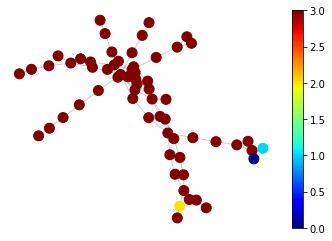

In [38]:
draw_graph(graphs[100])

/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


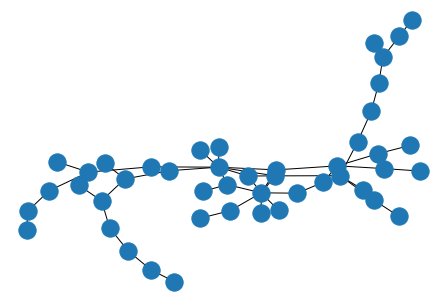

In [42]:
nx.draw(graphs[16], cmap = plt.get_cmap('jet'))
plt.show()